<a href="https://www.kaggle.com/code/swish9/profile-suggestion-testing?scriptVersionId=186209347" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 1.8 MB/s eta 0:00:00a 0:00:01m


In [2]:
!pip install networkx

In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer, BertForMaskedLM, BertTokenizer, XLNetLMHeadModel, XLNetTokenizer,T5ForConditionalGeneration, T5Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stopwords
import string
import matplotlib.pyplot as plt
import networkx as nx
import keras
import keras_nlp
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import plotly.graph_objects as go
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-06-30 09:02:17.023438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 09:02:17.023577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 09:02:17.155119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
profiles = [
    {
        "name": "Alice Johnson",
        "bio": "Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp."
    },
    {
        "name": "Bob Smith",
        "bio": "Project Manager with a strong background in finance and operations. Over 8 years of experience in managing cross-functional teams and driving project success. Adept at agile methodologies and risk management. Certified PMP."
    },
    {
        "name": "Carol Martinez",
        "bio": "Data Scientist with expertise in machine learning, data analysis, and visualization. Proficient in Python, R, and SQL. Passionate about uncovering insights from data and helping businesses make data-driven decisions. Published several papers on predictive analytics."
    },
    {
        "name": "David Lee",
        "bio": "Marketing Specialist with over 7 years of experience in digital marketing, SEO, and content strategy. Proven track record in increasing brand awareness and driving online engagement. Skilled in social media management and email marketing campaigns."
    },
    {
        "name": "Eve Kim",
        "bio": "Human Resources Manager with a focus on talent acquisition, employee engagement, and organizational development. Experienced in implementing HR strategies that align with business goals. Strong interpersonal skills and a passion for fostering a positive work environment."
    },
    {
        "name": "Frank Thompson",
        "bio": "Graphic Designer with a keen eye for detail and a passion for creativity. Over 6 years of experience in designing logos, websites, and marketing materials. Proficient in Adobe Creative Suite and web design tools. Strong portfolio showcasing diverse design projects."
    },
    {
        "name": "Grace Chen",
        "bio": "Product Manager with a background in software development and UX design. Skilled in product lifecycle management, market research, and user-centered design. Led the development of several successful products from concept to launch. Excellent problem-solving skills."
    },
    {
        "name": "Henry Davis",
        "bio": "Financial Analyst with expertise in financial modeling, forecasting, and data analysis. Over 5 years of experience in the banking and finance sector. Strong analytical skills and proficiency in Excel, Python, and financial software. MBA in Finance."
    },
    {
        "name": "Ivy Patel",
        "bio": "Content Writer and Editor with a passion for storytelling and communication. Over 8 years of experience in creating engaging content for blogs, websites, and social media. Skilled in SEO, copywriting, and content strategy. Strong portfolio of published work."
    },
    {
        "name": "Jack Wilson",
        "bio": "Cybersecurity Specialist with expertise in network security, threat analysis, and incident response. Over 7 years of experience in protecting organizational assets and ensuring compliance with security standards. Certified CISSP and CEH."
    }
]

In [6]:
bios = [profile['bio'] for profile in profiles]

In [7]:
embeddings = model.encode(bios)

embeddings.shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(10, 768)

In [8]:
similarity_matrix = cosine_similarity(embeddings)
similarity_matrix

array([[1.0000001 , 0.5943761 , 0.5964256 , 0.6459023 , 0.47328472,
        0.65025055, 0.5605971 , 0.49895355, 0.49999428, 0.508439  ],
       [0.5943761 , 1.        , 0.51091766, 0.57024384, 0.5615783 ,
        0.54916704, 0.68747187, 0.57218957, 0.40071386, 0.508289  ],
       [0.5964256 , 0.51091766, 1.0000001 , 0.53696096, 0.5190144 ,
        0.57000893, 0.5188238 , 0.6814975 , 0.45478234, 0.5439342 ],
       [0.6459023 , 0.57024384, 0.53696096, 0.9999998 , 0.540951  ,
        0.7348972 , 0.6027703 , 0.551623  , 0.6338295 , 0.5412584 ],
       [0.47328472, 0.5615783 , 0.5190144 , 0.540951  , 0.99999976,
        0.5257412 , 0.5992513 , 0.5124726 , 0.43229735, 0.43458825],
       [0.65025055, 0.54916704, 0.57000893, 0.7348972 , 0.5257412 ,
        1.0000002 , 0.64808255, 0.5649692 , 0.61680007, 0.5238197 ],
       [0.5605971 , 0.68747187, 0.5188238 , 0.6027703 , 0.5992513 ,
        0.64808255, 1.        , 0.5325567 , 0.40812835, 0.48690635],
       [0.49895355, 0.57218957, 0.6814975

In [9]:
def find_top_matches(similarity_matrix, profile_index, top_n=3):
    similarity_scores = similarity_matrix[profile_index]
    top_indices = np.argsort(-similarity_scores)[1:top_n+1]
    
    return top_indices

In [10]:
profile_index = 0
top_matches = find_top_matches(similarity_matrix, profile_index)

print(profiles[profile_index]['bio'],'\n')
for match_index in top_matches:
    print(f"Matched Profile: {profiles[match_index]['name']}")
    print(f"Bio: {profiles[match_index]['bio']}\n")

Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp. 

Matched Profile: Frank Thompson
Bio: Graphic Designer with a keen eye for detail and a passion for creativity. Over 6 years of experience in designing logos, websites, and marketing materials. Proficient in Adobe Creative Suite and web design tools. Strong portfolio showcasing diverse design projects.

Matched Profile: David Lee
Bio: Marketing Specialist with over 7 years of experience in digital marketing, SEO, and content strategy. Proven track record in increasing brand awareness and driving online engagement. Skilled in social media management and email marketing campaigns.

Matched Profile: Carol Martinez
Bio: Data Scientist with expertise in machine learning, data analysis, and visualization. Proficient in Python, R, and SQL. Passionate about 

# With interests 

In [11]:
profiles = [
    {
        "name": "Alice Johnson",
        "bio": "Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp.",
        "interests": {
            "reads_books": 80, 
            "plays_sports": 20,
            "travels": 50
        }
    },
    {
        "name": "Bob Smith",
        "bio": "Project Manager with a strong background in finance and operations. Over 8 years of experience in managing cross-functional teams and driving project success. Adept at agile methodologies and risk management. Certified PMP.",
        "interests": {
            "reads_books": 60,
            "plays_sports": 70,
            "travels": 30
        }
    },
    {
        "name": "Carol Martinez",
        "bio": "Data Scientist with expertise in machine learning, data analysis, and visualization. Proficient in Python, R, and SQL. Passionate about uncovering insights from data and helping businesses make data-driven decisions. Published several papers on predictive analytics.",
        "interests": {
            "reads_books": 90,
            "plays_sports": 40,
            "travels": 60
        }
    },
    {
        "name": "David Lee",
        "bio": "Marketing Specialist with over 7 years of experience in digital marketing, SEO, and content strategy. Proven track record in increasing brand awareness and driving online engagement. Skilled in social media management and email marketing campaigns.",
        "interests": {
            "reads_books": 30,
            "plays_sports": 80,
            "travels": 40
        }
    },
    {
        "name": "Eve Kim",
        "bio": "Human Resources Manager with a focus on talent acquisition, employee engagement, and organizational development. Experienced in implementing HR strategies that align with business goals. Strong interpersonal skills and a passion for fostering a positive work environment.",
        "interests": {
            "reads_books": 50,
            "plays_sports": 60,
            "travels": 70
        }
    },
    {
        "name": "Frank Thompson",
        "bio": "Graphic Designer with a keen eye for detail and a passion for creativity. Over 6 years of experience in designing logos, websites, and marketing materials. Proficient in Adobe Creative Suite and web design tools. Strong portfolio showcasing diverse design projects.",
        "interests": {
            "reads_books": 70,
            "plays_sports": 20,
            "travels": 90
        }
    },
    {
        "name": "Grace Chen",
        "bio": "Product Manager with a background in software development and UX design. Skilled in product lifecycle management, market research, and user-centered design. Led the development of several successful products from concept to launch. Excellent problem-solving skills.",
        "interests": {
            "reads_books": 80,
            "plays_sports": 50,
            "travels": 40
        }
    },
    {
        "name": "Henry Davis",
        "bio": "Financial Analyst with expertise in financial modeling, forecasting, and data analysis. Over 5 years of experience in the banking and finance sector. Strong analytical skills and proficiency in Excel, Python, and financial software. MBA in Finance.",
        "interests": {
            "reads_books": 40,
            "plays_sports": 60,
            "travels": 80
        }
    },
    {
        "name": "Ivy Patel",
        "bio": "Content Writer and Editor with a passion for storytelling and communication. Over 8 years of experience in creating engaging content for blogs, websites, and social media. Skilled in SEO, copywriting, and content strategy. Strong portfolio of published work.",
        "interests": {
            "reads_books": 90,
            "plays_sports": 10,
            "travels": 70
        }
    },
    {
        "name": "Jack Wilson",
        "bio": "Cybersecurity Specialist with expertise in network security, threat analysis, and incident response. Over 7 years of experience in protecting organizational assets and ensuring compliance with security standards. Certified CISSP and CEH.",
        "interests": {
            "reads_books": 60,
            "plays_sports": 90,
            "travels": 30
        }
    }
]

In [12]:
def calculate_combined_similarity(embeddings, profiles, weight_bio=0.7, weight_interests=0.3):
    bio_similarity = cosine_similarity(embeddings)
    interest_vectors = np.array([[profile['interests']['reads_books'],
                                  profile['interests']['plays_sports'],
                                  profile['interests']['travels']] for profile in profiles])
    interest_vectors = interest_vectors / 100.0 
    interest_similarity = cosine_similarity(interest_vectors)
    combined_similarity = (weight_bio * bio_similarity) + (weight_interests * interest_similarity)
    return combined_similarity

In [13]:
combined_similarity_matrix = calculate_combined_similarity(embeddings, profiles)

In [14]:
def find_top_matches(combined_similarity_matrix, profile_index, top_n=3):
    similarity_scores = combined_similarity_matrix[profile_index]
    top_indices = np.argsort(-similarity_scores)[1:top_n+1] 
    
    return top_indices

In [15]:
profile_index = 3
top_matches = find_top_matches(similarity_matrix, profile_index)

print(profiles[profile_index]['bio'],'\n')

for match_index in top_matches:
    print(f"Matched Profile: {profiles[match_index]['name']}")
    print(f"Bio: {profiles[match_index]['bio']}\n")

Marketing Specialist with over 7 years of experience in digital marketing, SEO, and content strategy. Proven track record in increasing brand awareness and driving online engagement. Skilled in social media management and email marketing campaigns. 

Matched Profile: Frank Thompson
Bio: Graphic Designer with a keen eye for detail and a passion for creativity. Over 6 years of experience in designing logos, websites, and marketing materials. Proficient in Adobe Creative Suite and web design tools. Strong portfolio showcasing diverse design projects.

Matched Profile: Alice Johnson
Bio: Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp.

Matched Profile: Ivy Patel
Bio: Content Writer and Editor with a passion for storytelling and communication. Over 8 years of experience in creating engaging content for 

In [16]:
bios = [profile['bio'] for profile in profiles]
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

embeddings = model.encode(bios)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
def calculate_combined_similarity(embeddings, profiles, user_weights):
    bio_similarity = cosine_similarity(embeddings)
    interest_vectors = np.array([[profile['interests']['reads_books'],
                                  profile['interests']['plays_sports'],
                                  profile['interests']['travels']] for profile in profiles])
    interest_vectors = interest_vectors / 100.0 
    interest_similarity = cosine_similarity(interest_vectors)
    combined_similarity = (user_weights['bio'] * bio_similarity) + \
                          (user_weights['reads_books'] * interest_similarity) + \
                          (user_weights['plays_sports'] * interest_similarity) + \
                          (user_weights['travels'] * interest_similarity)
    
    return combined_similarity

In [18]:
user_weights = {
    "bio": 0.5,  # 50%
    "reads_books": 0.2,  
    "plays_sports": 0.2, 
    "travels": 0.1  
}

combined_similarity_matrix = calculate_combined_similarity(embeddings, profiles, user_weights)

In [19]:
def find_top_matches(combined_similarity_matrix, profile_index, top_n=3):
    similarity_scores = combined_similarity_matrix[profile_index]
    
    top_indices = np.argsort(-similarity_scores)[1:top_n+1]  
    
    return top_indices

In [20]:
profile_index = 8
top_matches = find_top_matches(combined_similarity_matrix, profile_index)

for match_index in top_matches:
    print(f"Matched Profile: {profiles[match_index]['name']}")
    print(f"Bio: {profiles[match_index]['bio']}")
    print(f"Interests: {profiles[match_index]['interests']}\n")

Matched Profile: Frank Thompson
Bio: Graphic Designer with a keen eye for detail and a passion for creativity. Over 6 years of experience in designing logos, websites, and marketing materials. Proficient in Adobe Creative Suite and web design tools. Strong portfolio showcasing diverse design projects.
Interests: {'reads_books': 70, 'plays_sports': 20, 'travels': 90}

Matched Profile: Alice Johnson
Bio: Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp.
Interests: {'reads_books': 80, 'plays_sports': 20, 'travels': 50}

Matched Profile: Carol Martinez
Bio: Data Scientist with expertise in machine learning, data analysis, and visualization. Proficient in Python, R, and SQL. Passionate about uncovering insights from data and helping businesses make data-driven decisions. Published several papers on predic

# BOG 

In [21]:
category_keywords = {
    "software": ["software", "engineer", "programming", "coding", "development", "python", "java", "cloud", "data", "technology"],
    "reads_books": ["book", "reading", "literature", "novel", "author", "library", "story", "fiction", "non-fiction", "biography"],
    "plays_sports": ["sports", "soccer", "basketball", "tennis", "baseball", "football", "cricket", "running", "athlete", "fitness"],
    "travels": ["travel", "trip", "vacation", "tourism", "destination", "explore", "journey", "adventure", "flight", "holiday"]
}

In [22]:
def calculate_category_scores(profiles, category_keywords):
    category_scores = {category: [] for category in category_keywords}
    for profile in profiles:
        bio = profile['bio'].lower()
        for category, keywords in category_keywords.items():
            score = sum(bio.count(word) for word in keywords)
            category_scores[category].append(score)
    return category_scores

In [23]:
category_scores = calculate_category_scores(profiles, category_keywords)

def calculate_probability_scores(category_scores):
    probability_scores = {}
    for category, scores in category_scores.items():
        total = sum(scores)
        if total > 0:
            probability_scores[category] = [score / total for score in scores]
        else:
            probability_scores[category] = [0 for _ in scores]
    return probability_scores

In [24]:
probability_scores = calculate_probability_scores(category_scores)

In [25]:
def calculate_combined_similarity(profiles, probability_scores, user_weights):
    num_profiles = len(profiles)
    combined_similarity = np.zeros((num_profiles, num_profiles))
    
    bios = [profile['bio'] for profile in profiles]
    vectorizer = CountVectorizer()
    bio_bow_matrix = vectorizer.fit_transform(bios)
    bio_similarity = cosine_similarity(bio_bow_matrix)
    
    for i in range(num_profiles):
        for j in range(num_profiles):
            interest_similarity = 0
            for category in category_keywords:
                interest_similarity += user_weights[category] * probability_scores[category][i] * probability_scores[category][j]
            
            combined_similarity[i][j] = user_weights['bio'] * bio_similarity[i][j] + interest_similarity
    return combined_similarity

In [26]:
user_weights = {
    "bio": 0.5,  
    "software": 0.2,  
    "reads_books": 0.1,  
    "plays_sports": 0.1,  
    "travels": 0.1   
}

In [27]:
combined_similarity_matrix = calculate_combined_similarity(profiles, probability_scores, user_weights)

def find_top_matches(combined_similarity_matrix, profile_index, top_n=3):
    similarity_scores = combined_similarity_matrix[profile_index]
    top_indices = np.argsort(-similarity_scores)[1:top_n+1] 
    
    return top_indices

In [28]:
profile_index = 0 
top_matches = find_top_matches(combined_similarity_matrix, profile_index)

for match_index in top_matches:
    print(f"Matched Profile: {profiles[match_index]['name']}")
    print(f"Bio: {profiles[match_index]['bio']}")
    print(f"Interests: {profiles[match_index]['interests']}\n")


Matched Profile: Henry Davis
Bio: Financial Analyst with expertise in financial modeling, forecasting, and data analysis. Over 5 years of experience in the banking and finance sector. Strong analytical skills and proficiency in Excel, Python, and financial software. MBA in Finance.
Interests: {'reads_books': 40, 'plays_sports': 60, 'travels': 80}

Matched Profile: Carol Martinez
Bio: Data Scientist with expertise in machine learning, data analysis, and visualization. Proficient in Python, R, and SQL. Passionate about uncovering insights from data and helping businesses make data-driven decisions. Published several papers on predictive analytics.
Interests: {'reads_books': 90, 'plays_sports': 40, 'travels': 60}

Matched Profile: David Lee
Bio: Marketing Specialist with over 7 years of experience in digital marketing, SEO, and content strategy. Proven track record in increasing brand awareness and driving online engagement. Skilled in social media management and email marketing campaigns

# RE

In [29]:
experience_pattern = r"\b\d+\b\s*(years|months)"
field_pattern = r"(software|engineering|finance|data science|marketing|human resources|graphic design|product management|financial analysis|content writing|cybersecurity)"
domain_pattern = r"(tech|finance|data|marketing|human resources|design|product management|finance)"
skillset_pattern = r"(python|java|cloud|data analysis|machine learning|digital marketing|design|product lifecycle|financial modeling|content writing|network security)"

In [30]:
def calculate_regex_scores(profiles, regex_patterns):
    scores = np.zeros((len(profiles), len(regex_patterns)))
    for i, profile in enumerate(profiles):
        bio = profile['bio'].lower()
        for j, pattern in enumerate(regex_patterns):
            matches = re.findall(pattern, bio)
            scores[i][j] = len(matches)
    return scores

In [31]:
regex_patterns = [experience_pattern, field_pattern, domain_pattern, skillset_pattern]
regex_scores = calculate_regex_scores(profiles, regex_patterns)

In [32]:
def calculate_combined_similarity(regex_scores, user_weights):
    num_profiles = regex_scores.shape[0]
    combined_similarity = np.zeros((num_profiles, num_profiles))
    
    for i in range(num_profiles):
        for j in range(num_profiles):
            weighted_sum = 0
            for k, param in enumerate(user_weights):  # Iterate over dictionary keys
                weighted_sum += user_weights[param] * regex_scores[i][k] * regex_scores[j][k]
            combined_similarity[i][j] = weighted_sum
    return combined_similarity

In [33]:
user_weights = {
    "experience": 0.4,
    "field": 0.3,
    "domain": 0.2,
    "skillset": 0.1
}

In [34]:
combined_similarity_matrix = calculate_combined_similarity(regex_scores, user_weights)
def find_top_matches(combined_similarity_matrix, profile_index, top_n=3):
    similarity_scores = combined_similarity_matrix[profile_index]
    top_indices = np.argsort(-similarity_scores)[1:top_n+1]
    
    return top_indices

In [35]:
profile_index = 5
top_matches = find_top_matches(combined_similarity_matrix, profile_index)

for match_index in top_matches:
    print(f"Matched Profile: {profiles[match_index]['name']}")
    print(f"Bio: {profiles[match_index]['bio']}")
    print(f"Interests: {profiles[match_index]['interests']}\n")

Matched Profile: Henry Davis
Bio: Financial Analyst with expertise in financial modeling, forecasting, and data analysis. Over 5 years of experience in the banking and finance sector. Strong analytical skills and proficiency in Excel, Python, and financial software. MBA in Finance.
Interests: {'reads_books': 40, 'plays_sports': 60, 'travels': 80}

Matched Profile: David Lee
Bio: Marketing Specialist with over 7 years of experience in digital marketing, SEO, and content strategy. Proven track record in increasing brand awareness and driving online engagement. Skilled in social media management and email marketing campaigns.
Interests: {'reads_books': 30, 'plays_sports': 80, 'travels': 40}

Matched Profile: Carol Martinez
Bio: Data Scientist with expertise in machine learning, data analysis, and visualization. Proficient in Python, R, and SQL. Passionate about uncovering insights from data and helping businesses make data-driven decisions. Published several papers on predictive analytics

# Bio Generations

In [36]:
model_name = 'gpt2-medium'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [37]:
def generate_bio_suggestions(input_bio, num_suggestions=3):
    prompt = f"Based on the following input bio: {input_bio}, generate professional bio suggestions that highlight key skills, experiences, and achievements. Each suggestion should be concise, engaging, and suitable for a LinkedIn profile or professional resume.\n\nSuggestions:"
    
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(
        inputs,
        max_length=150,
        num_return_sequences=num_suggestions,
        no_repeat_ngram_size=2,
        temperature=0.7,
        do_sample=True 
    )

    suggestions = [tokenizer.decode(output, skip_special_tokens=True).replace(prompt, '').strip() for output in outputs]
    return suggestions

In [38]:
user_input_bio = "Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp."
suggestions = generate_bio_suggestions(user_input_bio)

for i, suggestion in enumerate(suggestions):
    print(f"Suggestion {i+1}: {suggestion}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggestion 1: 'sabotage' (as in 'defuse' or 'use')
, 'fog'
. 'dissolve' is an old style term used to describe the process of removing information from a computer system to prevent it from being used in a terrorist attack. The term has been
Suggestion 2: ... I have a passion for creating professional software, not about sales or marketing. I am passionate about building software that can be used by anyone in a variety of industries. My company has a wide variety, from software development to data science and data visualization to medical devices and healthcare. There is a
Suggestion 3: "I love programming and I'd love to see you go to work on something cool."
...
: Expert in software engineering and best-in-class development skills. This candidate has experience writing software for the web, mobile, web-based applications and databases. Experience writing business applications,


In [39]:
model_name = 'distilgpt2'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [40]:
def generate_bio_suggestions(input_bio, num_suggestions=3):
    prompt = f"Based on the following input bio: {input_bio}, generate professional bio suggestions that highlight key skills, experiences, and achievements. Each suggestion should be concise, engaging, and suitable for a LinkedIn profile or professional resume.\n\nSuggestions:"
    
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(
        inputs,
        max_length=150,
        num_return_sequences=num_suggestions,
        no_repeat_ngram_size=2,
        temperature=0.7,
        do_sample=True 
    )

    suggestions = [tokenizer.decode(output, skip_special_tokens=True).replace(prompt, '').strip() for output in outputs]
    return suggestions

In [41]:
user_input_bio = "Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp."
suggestions = generate_bio_suggestions(user_input_bio)

for i, suggestion in enumerate(suggestions):
    print(f"Suggestion {i+1}: {suggestion}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Suggestion 1: 1. Do not use any language other than English. Use this language to communicate with your colleagues. You should know the syntax and syntax of the language, including the basic spelling, punctuation, as well as a list of relevant phrases. This will make you more likely to learn the basics of a language
Suggestion 2: This study was taken with the intent of conducting a qualitative and quantitative assessment of how a developer can utilize Python and an open source language. This was completed with a minimum of 4 hours of written interview time and time. We have selected the language for the study and are confident that it will be the most accessible
Suggestion 3: If you're interested, please contact me on Twitter @daniely. I'll be happy to help you.


In [42]:
model_name = 'bert-base-uncased'
model = BertForMaskedLM.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [43]:
def generate_bio_suggestions(input_bio, num_suggestions=3):
    prompt = f"Based on the following input bio: {input_bio}, generate professional bio suggestions that highlight key skills, experiences, and achievements. Each suggestion should be concise, engaging, and suitable for a LinkedIn profile or professional resume.\n\nSuggestions:"
    
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(
        inputs,
        max_length=150,
        num_return_sequences=num_suggestions,
        no_repeat_ngram_size=2,
        temperature=0.7,
        do_sample=True 
    )

    suggestions = [tokenizer.decode(output, skip_special_tokens=True).replace(prompt, '').strip() for output in outputs]
    return suggestions

In [44]:
user_input_bio = "Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp."
suggestions = generate_bio_suggestions(user_input_bio)

for i, suggestion in enumerate(suggestions):
    print(f"Suggestion {i+1}: {suggestion}")

Suggestion 1: based on the following input bio : experienced software engineer with 10 years in the tech industry. skilled in python, java, and cloud computing. passionate about developing scalable software solutions and mentoring junior developers. currently leading a team at techcorp., generate professional bio suggestions that highlight key skills, experiences, and achievements. each suggestion should be concise, engaging, and suitable for a linkedin profile or professional resume. suggestions : see : professional.. a professional or a technical. experience.??. also used for designing a website. refer. see. ; ;. #. =. @. / php. php ; # =? #? ;? = ; name ; = # ; is also very very passionate and often using
Suggestion 2: based on the following input bio : experienced software engineer with 10 years in the tech industry. skilled in python, java, and cloud computing. passionate about developing scalable software solutions and mentoring junior developers. currently leading a team at tech

In [45]:
model_name = 'xlnet-base-cased'
model = XLNetLMHeadModel.from_pretrained(model_name)
tokenizer = XLNetTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [46]:
def generate_bio_suggestions(input_bio, num_suggestions=3):
    prompt = f"Based on the following input bio: {input_bio}, generate professional bio suggestions that highlight key skills, experiences, and achievements. Each suggestion should be concise, engaging, and suitable for a LinkedIn profile or professional resume.\n\nSuggestions:"
    
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(
        inputs,
        max_length=150,
        num_return_sequences=num_suggestions,
        no_repeat_ngram_size=2,
        temperature=0.7,
        do_sample=True 
    )

    suggestions = [tokenizer.decode(output, skip_special_tokens=True).replace(prompt, '').strip() for output in outputs]
    return suggestions

In [47]:
user_input_bio = "Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp."
suggestions = generate_bio_suggestions(user_input_bio)

for i, suggestion in enumerate(suggestions):
    print(f"Suggestion {i+1}: {suggestion}")

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (-1). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


Suggestion 1: Based on the following input bio: Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp., generate professional bio suggestions that highlight key skills, experiences, and achievements. Each suggestion should be concise, engaging, and suitable for a LinkedIn profile or professional resume. Suggestions:: a long-standing experience in IT, has a "broad-ranging" time and background in technology industry, working in many technologies, or is a certified IT professional, a former CEO, an executive or a senior management officer. The following information will be used to help you find
Suggestion 2: Based on the following input bio: Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions a

In [48]:
model_name = 't5-small'
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [49]:
def generate_bio_suggestions(input_bio, num_suggestions=3):
    prompt = f"Based on the following input bio: {input_bio}, generate professional bio suggestions that highlight key skills, experiences, and achievements. Each suggestion should be concise, engaging, and suitable for a LinkedIn profile or professional resume.\n\nSuggestions:"
    
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(
        inputs,
        max_length=150,
        num_return_sequences=num_suggestions,
        no_repeat_ngram_size=2,
        temperature=0.7,
        do_sample=True 
    )

    suggestions = [tokenizer.decode(output, skip_special_tokens=True).replace(prompt, '').strip() for output in outputs]
    return suggestions

In [50]:
user_input_bio = "Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp."
suggestions = generate_bio_suggestions(user_input_bio)

for i, suggestion in enumerate(suggestions):
    print(f"Suggestion {i+1}: {suggestion}")

Suggestion 1: a professional bio and if you are not an experienced Software Engineer, generate professional career bio suggestions that highlight key skills, experiences, and achievements. Each suggestion should be concise, engaging, & suitable for pc profile or professional resume.
Suggestion 2: ,, and achievements.,, opportunities, challenges, achievements and skills. A bio is an experienced software engineer and 10 years in the tech industry...: Experienced Software Engineer with 10+ years experience.: in Python, Java, software engineering. Experience is::::::: Python Python and Java (and cloud computing). scalable solutions. Passionate about developing skalier solutions and mentoring junior developers.
Suggestion 3: a bio about key skills, experiences, and achievements.: An Experienced Software Engineer with 10 years in the tech industry. Experience in Python, Java, or cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currentl

# Ngram

In [51]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(3, 3))
X = vectorizer.fit_transform(bios)

In [52]:
similarity_matrix = cosine_similarity(X)

In [53]:
def find_top_matches(similarity_matrix, profile_index, top_n=3):
    similarity_scores = similarity_matrix[profile_index]
    top_indices = np.argsort(-similarity_scores)[1:top_n+1]
    return top_indices

In [54]:
profile_index = 0
top_matches = find_top_matches(similarity_matrix, profile_index)

print("Original Bio:\n", bios[profile_index], '\n\n')
for match_index in top_matches:
    print(f"Matched Profile: {profiles[match_index]['name']}")
    print(f"Bio: {bios[match_index]}\n")

Original Bio:
 Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp. 


Matched Profile: Bob Smith
Bio: Project Manager with a strong background in finance and operations. Over 8 years of experience in managing cross-functional teams and driving project success. Adept at agile methodologies and risk management. Certified PMP.

Matched Profile: Carol Martinez
Bio: Data Scientist with expertise in machine learning, data analysis, and visualization. Proficient in Python, R, and SQL. Passionate about uncovering insights from data and helping businesses make data-driven decisions. Published several papers on predictive analytics.

Matched Profile: David Lee
Bio: Marketing Specialist with over 7 years of experience in digital marketing, SEO, and content strategy. Proven track record in increasing brand awarene

# Clustering Profiles 

In [55]:
profiles = [
    {
        "name": "Alice Johnson",
        "bio": "Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp.",
        "interests": {
            "reads_books": 80, 
            "plays_sports": 20,
            "travels": 50
        },
        "location": "Bangalore"
    },
    {
        "name": "Bob Smith",
        "bio": "Project Manager with a strong background in finance and operations. Over 8 years of experience in managing cross-functional teams and driving project success. Adept at agile methodologies and risk management. Certified PMP.",
        "interests": {
            "reads_books": 60,
            "plays_sports": 70,
            "travels": 30
        },
        "location": "Mumbai"
    },
    {
        "name": "Carol Martinez",
        "bio": "Data Scientist with expertise in machine learning, data analysis, and visualization. Proficient in Python, R, and SQL. Passionate about uncovering insights from data and helping businesses make data-driven decisions. Published several papers on predictive analytics.",
        "interests": {
            "reads_books": 90,
            "plays_sports": 40,
            "travels": 60
        },
        "location": "Delhi"
    },
    {
        "name": "David Lee",
        "bio": "Marketing Specialist with over 7 years of experience in digital marketing, SEO, and content strategy. Proven track record in increasing brand awareness and driving online engagement. Skilled in social media management and email marketing campaigns.",
        "interests": {
            "reads_books": 30,
            "plays_sports": 80,
            "travels": 40
        },
        "location": "Hyderabad"
    },
    {
        "name": "Eve Kim",
        "bio": "Human Resources Manager with a focus on talent acquisition, employee engagement, and organizational development. Experienced in implementing HR strategies that align with business goals. Strong interpersonal skills and a passion for fostering a positive work environment.",
        "interests": {
            "reads_books": 50,
            "plays_sports": 60,
            "travels": 70
        },
        "location": "Chennai"
    },
    {
        "name": "Frank Thompson",
        "bio": "Graphic Designer with a keen eye for detail and a passion for creativity. Over 6 years of experience in designing logos, websites, and marketing materials. Proficient in Adobe Creative Suite and web design tools. Strong portfolio showcasing diverse design projects.",
        "interests": {
            "reads_books": 70,
            "plays_sports": 20,
            "travels": 90
        },
        "location": "Pune"
    },
    {
        "name": "Grace Chen",
        "bio": "Product Manager with a background in software development and UX design. Skilled in product lifecycle management, market research, and user-centered design. Led the development of several successful products from concept to launch. Excellent problem-solving skills.",
        "interests": {
            "reads_books": 80,
            "plays_sports": 50,
            "travels": 40
        },
        "location": "Kolkata"
    },
    {
        "name": "Henry Davis",
        "bio": "Financial Analyst with expertise in financial modeling, forecasting, and data analysis. Over 5 years of experience in the banking and finance sector. Strong analytical skills and proficiency in Excel, Python, and financial software. MBA in Finance.",
        "interests": {
            "reads_books": 40,
            "plays_sports": 60,
            "travels": 80
        },
        "location": "Indore"
    },
    {
        "name": "Ivy Patel",
        "bio": "Content Writer and Editor with a passion for storytelling and communication. Over 8 years of experience in creating engaging content for blogs, websites, and social media. Skilled in SEO, copywriting, and content strategy. Strong portfolio of published work.",
        "interests": {
            "reads_books": 90,
            "plays_sports": 10,
            "travels": 70
        },
        "location": "Noida"
    },
    {
        "name": "Jack Wilson",
        "bio": "Cybersecurity Specialist with expertise in network security, threat analysis, and incident response. Over 7 years of experience in protecting organizational assets and ensuring compliance with security standards. Certified CISSP and CEH.",
        "interests": {
            "reads_books": 60,
            "plays_sports": 90,
            "travels": 30
        },
        "location": "Nagpur"
    },
    {
        "name": "Karen White",
        "bio": "UX Designer with a passion for creating intuitive and user-friendly interfaces. Over 5 years of experience in wireframing, prototyping, and user testing. Skilled in Sketch, Figma, and Adobe XD. Dedicated to improving user experience through innovative design solutions.",
        "interests": {
            "reads_books": 40,
            "plays_sports": 50,
            "travels": 80
        },
        "location": "Bangalore"
    },
    {
        "name": "Larry Brown",
        "bio": "Operations Manager with a strong background in supply chain management and logistics. Over 10 years of experience in optimizing operations and reducing costs. Skilled in Lean Six Sigma and project management. Proven track record in improving efficiency and productivity.",
        "interests": {
            "reads_books": 50,
            "plays_sports": 60,
            "travels": 70
        },
        "location": "Mumbai"
    },
    {
        "name": "Nancy Green",
        "bio": "Digital Marketing Expert with over 8 years of experience in SEO, SEM, and social media marketing. Proven ability to drive traffic and increase sales through innovative digital marketing strategies. Certified Google Analytics and AdWords specialist.",
        "interests": {
            "reads_books": 60,
            "plays_sports": 40,
            "travels": 80
        },
        "location": "Delhi"
    },
    {
        "name": "Oscar Harris",
        "bio": "Mobile App Developer with expertise in iOS and Android development. Over 6 years of experience in building user-friendly and high-performance mobile applications. Proficient in Swift, Kotlin, and Flutter. Strong portfolio of published apps.",
        "interests": {
            "reads_books": 70,
            "plays_sports": 60,
            "travels": 50
        },
        "location": "Hyderabad"
    },
    {
        "name": "Paula Adams",
        "bio": "Sales Manager with a proven track record of exceeding sales targets and driving revenue growth. Over 9 years of experience in B2B and B2C sales. Skilled in customer relationship management and strategic planning. Strong leadership and team-building skills.",
        "interests": {
            "reads_books": 40,
            "plays_sports": 70,
            "travels": 60
        },
        "location": "Chennai"
    },
    {
        "name": "Quincy Hall",
        "bio": "Business Analyst with expertise in data analysis, process improvement, and project management. Over 5 years of experience in identifying business needs and implementing effective solutions. Proficient in SQL, Excel, and business intelligence tools.",
        "interests": {
            "reads_books": 50,
            "plays_sports": 50,
            "travels": 70
        },
        "location": "Pune"
    },
    {
        "name": "Rachel King",
        "bio": "Content Strategist with a background in journalism and digital media. Over 7 years of experience in creating and managing content strategies for various brands. Skilled in SEO, copywriting, and social media marketing. Strong portfolio of successful campaigns.",
        "interests": {
            "reads_books": 80,
            "plays_sports": 30,
            "travels": 70
        },
        "location": "Kolkata"
    },
    {
        "name": "Steven Walker",
        "bio": "Software Developer with expertise in full-stack development and DevOps. Over 6 years of experience in building and deploying scalable web applications. Proficient in JavaScript, Python, and Docker. Passionate about open-source contributions and continuous learning.",
        "interests": {
            "reads_books": 60,
            "plays_sports": 40,
            "travels": 80
        },
        "location": "Indore"
    },
    {
        "name": "Tina Scott",
        "bio": "Human Resources Specialist with a focus on employee relations and performance management. Over 5 years of experience in HR roles, ensuring compliance with labor laws and promoting a positive work environment. Skilled in conflict resolution and employee engagement.",
        "interests": {
            "reads_books": 50,
            "plays_sports": 70,
            "travels": 60
        },
        "location": "Noida"
    },
    {
        "name": "Liam Patel",
        "bio": "AI Researcher specializing in natural language processing and deep learning. PhD in Computer Science with a focus on neural networks and text generation models. Experienced in Python, TensorFlow, and PyTorch. Published several papers in top AI conferences.",
        "interests": {
            "reads_books": 80,
            "plays_sports": 30,
            "travels": 40
        },
        "location": "Bangalore"
    },
    {
        "name": "Sophia Gupta",
        "bio": "UX/UI Designer with a passion for creating intuitive and visually appealing user interfaces. Skilled in wireframing, prototyping, and user research. Proficient in Sketch, Figma, and Adobe XD. Strong advocate for user-centered design principles.",
        "interests": {
            "reads_books": 60,
            "plays_sports": 20,
            "travels": 70
        },
        "location": "Mumbai"
    },
    {
        "name": "Noah Kumar",
        "bio": "Blockchain Developer specializing in decentralized applications (dApps) and smart contracts. Experienced in Ethereum and Solidity. Strong background in cryptography and secure coding practices. Contributed to open-source blockchain projects.",
        "interests": {
            "reads_books": 70,
            "plays_sports": 40,
            "travels": 50
        },
        "location": "Delhi"
    },
    {
        "name": "Olivia Sharma",
        "bio": "Environmental Scientist with expertise in climate change research and environmental policy. PhD in Environmental Science with a focus on sustainable development. Skilled in GIS, data analysis, and environmental impact assessments.",
        "interests": {
            "reads_books": 50,
            "plays_sports": 60,
            "travels": 30
        },
        "location": "Hyderabad"
    },
    {
        "name": "William Reddy",
        "bio": "Architect with a passion for sustainable design and urban planning. Over 10 years of experience in designing eco-friendly buildings and public spaces. Skilled in AutoCAD, Revit, and 3D modeling software.",
        "interests": {
            "reads_books": 40,
            "plays_sports": 30,
            "travels": 80
        },
        "location": "Chennai"
    },
    {
        "name": "Emma Verma",
        "bio": "Healthcare Administrator with a background in hospital management and healthcare policy. Experienced in optimizing healthcare operations and ensuring compliance with regulatory standards. Strong interpersonal and leadership skills.",
        "interests": {
            "reads_books": 70,
            "plays_sports": 20,
            "travels": 40
        },
        "location": "Pune"
    },
    {
        "name": "Alexander Singh",
        "bio": "Civil Engineer specializing in infrastructure development and project management. Experienced in structural design, construction supervision, and budget management. Skilled in CAD software and civil engineering principles.",
        "interests": {
            "reads_books": 30,
            "plays_sports": 50,
            "travels": 60
        },
        "location": "Kolkata"
    },
    {
        "name": "Mia Chopra",
        "bio": "Digital Marketer with a focus on content strategy and social media management. Over 5 years of experience in developing and executing digital marketing campaigns. Skilled in SEO, SEM, and email marketing.",
        "interests": {
            "reads_books": 60,
            "plays_sports": 40,
            "travels": 70
        },
        "location": "Nagpur"
    },
    {
        "name": "Ethan Rao",
        "bio": "Software Developer specializing in web application development. Proficient in JavaScript, React, and Node.js. Experienced in building scalable and responsive web solutions. Passionate about open-source development.",
        "interests": {
            "reads_books": 50,
            "plays_sports": 30,
            "travels": 50
        },
        "location": "Indore"
    },
    {
        "name": "Ava Mishra",
        "bio": "Financial Analyst with expertise in financial modeling and investment analysis. MBA in Finance with a strong background in quantitative analysis and risk management. Skilled in Excel, SQL, and financial software.",
        "interests": {
            "reads_books": 40,
            "plays_sports": 60,
            "travels": 40
        },
        "location": "Jaipur"
    },
    {
        "name": "James Kumar",
        "bio": "Sales Manager with a proven track record in B2B sales and client relationship management. Experienced in leading sales teams to exceed revenue targets. Skilled in negotiation, strategic planning, and market analysis.",
        "interests": {
            "reads_books": 30,
            "plays_sports": 50,
            "travels": 30
        },
        "location": "Lucknow"
    },
    {
        "name": "Charlotte Joshi",
        "bio": "Human Resources Specialist with a focus on talent acquisition and employee development. Experienced in HR strategy development and implementation. Strong communication and organizational skills.",
        "interests": {
            "reads_books": 50,
            "plays_sports": 40,
            "travels": 60
        },
        "location": "Ahmedabad"
    },
    {
        "name": "Michael Mittal",
        "bio": "Mechanical Engineer with expertise in product design and manufacturing processes. Experienced in CAD/CAM software and prototyping. Strong analytical skills and problem-solving abilities.",
        "interests": {
            "reads_books": 40,
            "plays_sports": 30,
            "travels": 50
        },
        "location": "Coimbatore"
    },
    {
        "name": "Isabella Rao",
        "bio": "Content Writer with a passion for creating engaging and informative content. Experienced in writing for various platforms including blogs, websites, and social media. Skilled in SEO and digital content strategy.",
        "interests": {
            "reads_books": 60,
            "plays_sports": 20,
            "travels": 70
        },
        "location": "Visakhapatnam"
    },
    {
        "name": "Lucas Khanna",
        "bio": "Graphic Designer with a creative flair for visual communication. Experienced in designing logos, posters, and branding materials. Proficient in Adobe Creative Suite and digital illustration.",
        "interests": {
            "reads_books": 30,
            "plays_sports": 40,
            "travels": 60
        },
        "location": "Surat"
    }
]

In [56]:
len(profiles)

34

In [57]:
X = np.array([[profile['interests']['reads_books'], 
               profile['interests']['plays_sports'], 
               profile['interests']['travels']] for profile in profiles])

In [58]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [59]:
eps = 0.5 
min_samples = 2 

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaled)

In [60]:
for profile, cluster_label in zip(profiles, clusters):
    profile['cluster'] = cluster_label

clusters_dict = defaultdict(list)

In [61]:
for profile in profiles:
    clusters_dict[profile['cluster']].append(profile)

In [62]:
for cluster, profiles_in_cluster in clusters_dict.items():
    print(f"Cluster {cluster}:")
    for profile in profiles_in_cluster:
        print(f"\t{profile['name']} - {profile['bio']}, Location: {profile['location']}")

Cluster -1:
	Alice Johnson - Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp., Location: Bangalore
	Bob Smith - Project Manager with a strong background in finance and operations. Over 8 years of experience in managing cross-functional teams and driving project success. Adept at agile methodologies and risk management. Certified PMP., Location: Mumbai
	Carol Martinez - Data Scientist with expertise in machine learning, data analysis, and visualization. Proficient in Python, R, and SQL. Passionate about uncovering insights from data and helping businesses make data-driven decisions. Published several papers on predictive analytics., Location: Delhi
	David Lee - Marketing Specialist with over 7 years of experience in digital marketing, SEO, and content strategy. Proven track record in increasing brand

In [63]:
def calculate_cosine_similarity(profile1, profile2):
    vector1 = np.array([profile1['interests']['reads_books'],
                        profile1['interests']['plays_sports'],
                        profile1['interests']['travels']])
    vector2 = np.array([profile2['interests']['reads_books'],
                        profile2['interests']['plays_sports'],
                        profile2['interests']['travels']])
    return cosine_similarity([vector1], [vector2])[0][0]

In [64]:
def find_most_similar_profiles_by_index(profile_index, profiles, top_n=3):
    input_profile = profiles[profile_index]

    input_cluster = input_profile['cluster']
    input_location = input_profile['location']
    candidates = [profile for profile in profiles
                  if profile['location'] == input_location and profile['cluster'] == input_cluster]
    candidates.sort(key=lambda x: calculate_cosine_similarity(input_profile, x), reverse=True)
    if input_profile in candidates:
        candidates.remove(input_profile)
    return candidates[:top_n]

In [65]:
input_profile_index = 3
similar_profiles = find_most_similar_profiles_by_index(input_profile_index, profiles)
input_profile = profiles[input_profile_index]
print(profiles[3])
print(f"3 Most Similar Profiles to '{input_profile['name']}' in {input_profile['location']} (Cluster {input_profile['cluster']}):")
for i, profile in enumerate(similar_profiles, start=1):
    print(f"{i}. {profile['name']} - {profile['bio']}")
    print(f"   Interests: Reads books: {profile['interests']['reads_books']}, Plays sports: {profile['interests']['plays_sports']}, Travels: {profile['interests']['travels']}")
    print(f"   Location: {profile['location']}")
    print(f"   Cluster: {profile['cluster']}")
    similarity_score = calculate_cosine_similarity(input_profile, profile)
    print(f"   Cosine Similarity Score: {similarity_score:.2f}")
    print()

{'name': 'David Lee', 'bio': 'Marketing Specialist with over 7 years of experience in digital marketing, SEO, and content strategy. Proven track record in increasing brand awareness and driving online engagement. Skilled in social media management and email marketing campaigns.', 'interests': {'reads_books': 30, 'plays_sports': 80, 'travels': 40}, 'location': 'Hyderabad', 'cluster': -1}
3 Most Similar Profiles to 'David Lee' in Hyderabad (Cluster -1):
1. Olivia Sharma - Environmental Scientist with expertise in climate change research and environmental policy. PhD in Environmental Science with a focus on sustainable development. Skilled in GIS, data analysis, and environmental impact assessments.
   Interests: Reads books: 50, Plays sports: 60, Travels: 30
   Location: Hyderabad
   Cluster: -1
   Cosine Similarity Score: 0.95

2. Oscar Harris - Mobile App Developer with expertise in iOS and Android development. Over 6 years of experience in building user-friendly and high-performance m

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

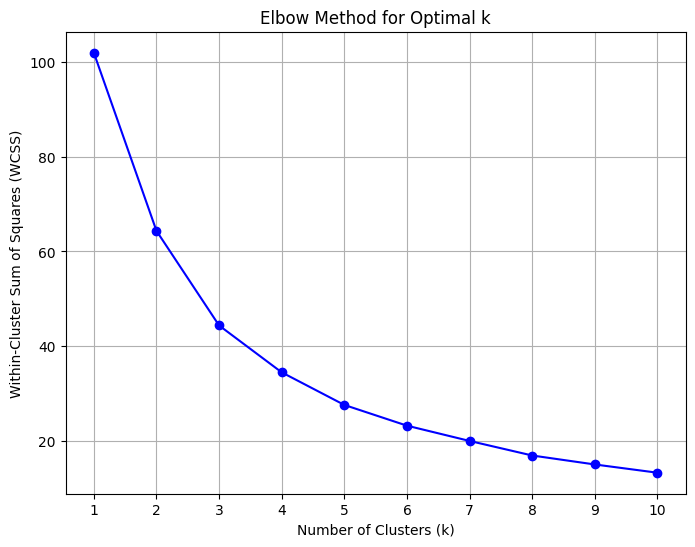

In [66]:
wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [67]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
for profile, cluster_label in zip(profiles, clusters):
    profile['cluster'] = cluster_label
for cluster_id in range(n_clusters):
    print(f"Cluster {cluster_id}:")
    for profile in profiles:
        if profile['cluster'] == cluster_id:
            print(f"\t{profile['name']} - {profile['bio']}, Location: {profile['location']}")
            print(f"\tInterests: Reads books: {profile['interests']['reads_books']}, Plays sports: {profile['interests']['plays_sports']}, Travels: {profile['interests']['travels']}")
    print()

Cluster 0:
	David Lee - Marketing Specialist with over 7 years of experience in digital marketing, SEO, and content strategy. Proven track record in increasing brand awareness and driving online engagement. Skilled in social media management and email marketing campaigns., Location: Hyderabad
	Interests: Reads books: 30, Plays sports: 80, Travels: 40
	Ava Mishra - Financial Analyst with expertise in financial modeling and investment analysis. MBA in Finance with a strong background in quantitative analysis and risk management. Skilled in Excel, SQL, and financial software., Location: Jaipur
	Interests: Reads books: 40, Plays sports: 60, Travels: 40
	James Kumar - Sales Manager with a proven track record in B2B sales and client relationship management. Experienced in leading sales teams to exceed revenue targets. Skilled in negotiation, strategic planning, and market analysis., Location: Lucknow
	Interests: Reads books: 30, Plays sports: 50, Travels: 30

Cluster 1:
	Carol Martinez - Dat

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [68]:
def find_most_similar_profiles_by_index(profile_index, profiles, top_n=3):
    input_profile = profiles[profile_index]

    input_cluster = input_profile['cluster']
    input_location = input_profile['location']
    candidates = [profile for profile in profiles
                  if profile['location'] == input_location and profile['cluster'] == input_cluster]
    candidates.sort(key=lambda x: calculate_cosine_similarity(input_profile, x), reverse=True)
    if input_profile in candidates:
        candidates.remove(input_profile)
    return candidates[:top_n]

In [69]:
input_profile_index = 3
similar_profiles = find_most_similar_profiles_by_index(input_profile_index, profiles)
input_profile = profiles[input_profile_index]
print(f"3 Most Similar Profiles to '{input_profile['name']}' in {input_profile['location']} (Cluster {input_profile['cluster']}):")
for i, profile in enumerate(similar_profiles, start=1):
    print(f"{i}. {profile['name']} - {profile['bio']}")
    print(f"   Interests: Reads books: {profile['interests']['reads_books']}, Plays sports: {profile['interests']['plays_sports']}, Travels: {profile['interests']['travels']}")
    print(f"   Location: {profile['location']}")
    print(f"   Cluster: {profile['cluster']}")
    similarity_score = calculate_cosine_similarity(input_profile, profile)
    print(f"   Cosine Similarity Score: {similarity_score:.2f}")
    print()

3 Most Similar Profiles to 'David Lee' in Hyderabad (Cluster 0):


In [70]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
for profile, cluster_label in zip(profiles, clusters):
    profile['cluster'] = cluster_label
for cluster_id in range(n_clusters):
    print(f"Cluster {cluster_id}:")
    for profile in profiles:
        if profile['cluster'] == cluster_id:
            print(f"\t{profile['name']} - {profile['bio']}, Location: {profile['location']}")
            print(f"\tInterests: Reads books: {profile['interests']['reads_books']}, Plays sports: {profile['interests']['plays_sports']}, Travels: {profile['interests']['travels']}")
    print()

Cluster 0:
	Frank Thompson - Graphic Designer with a keen eye for detail and a passion for creativity. Over 6 years of experience in designing logos, websites, and marketing materials. Proficient in Adobe Creative Suite and web design tools. Strong portfolio showcasing diverse design projects., Location: Pune
	Interests: Reads books: 70, Plays sports: 20, Travels: 90
	Nancy Green - Digital Marketing Expert with over 8 years of experience in SEO, SEM, and social media marketing. Proven ability to drive traffic and increase sales through innovative digital marketing strategies. Certified Google Analytics and AdWords specialist., Location: Delhi
	Interests: Reads books: 60, Plays sports: 40, Travels: 80
	Steven Walker - Software Developer with expertise in full-stack development and DevOps. Over 6 years of experience in building and deploying scalable web applications. Proficient in JavaScript, Python, and Docker. Passionate about open-source contributions and continuous learning., Locati

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [71]:
def find_most_similar_profiles_by_index(profile_index, profiles, top_n=3):
    input_profile = profiles[profile_index]

    input_cluster = input_profile['cluster']
    input_location = input_profile['location']
    candidates = [profile for profile in profiles
                  if profile['location'] == input_location and profile['cluster'] == input_cluster]
    candidates.sort(key=lambda x: calculate_cosine_similarity(input_profile, x), reverse=True)
    if input_profile in candidates:
        candidates.remove(input_profile)
    return candidates[:top_n]

In [72]:
input_profile_index = 3
similar_profiles = find_most_similar_profiles_by_index(input_profile_index, profiles)
input_profile = profiles[input_profile_index]
print(f"3 Most Similar Profiles to '{input_profile['name']}' in {input_profile['location']} (Cluster {input_profile['cluster']}):")
for i, profile in enumerate(similar_profiles, start=1):
    print(f"{i}. {profile['name']} - {profile['bio']}")
    print(f"   Interests: Reads books: {profile['interests']['reads_books']}, Plays sports: {profile['interests']['plays_sports']}, Travels: {profile['interests']['travels']}")
    print(f"   Location: {profile['location']}")
    print(f"   Cluster: {profile['cluster']}")
    similarity_score = calculate_cosine_similarity(input_profile, profile)
    print(f"   Cosine Similarity Score: {similarity_score:.2f}")
    print()

3 Most Similar Profiles to 'David Lee' in Hyderabad (Cluster 2):
1. Olivia Sharma - Environmental Scientist with expertise in climate change research and environmental policy. PhD in Environmental Science with a focus on sustainable development. Skilled in GIS, data analysis, and environmental impact assessments.
   Interests: Reads books: 50, Plays sports: 60, Travels: 30
   Location: Hyderabad
   Cluster: 2
   Cosine Similarity Score: 0.95



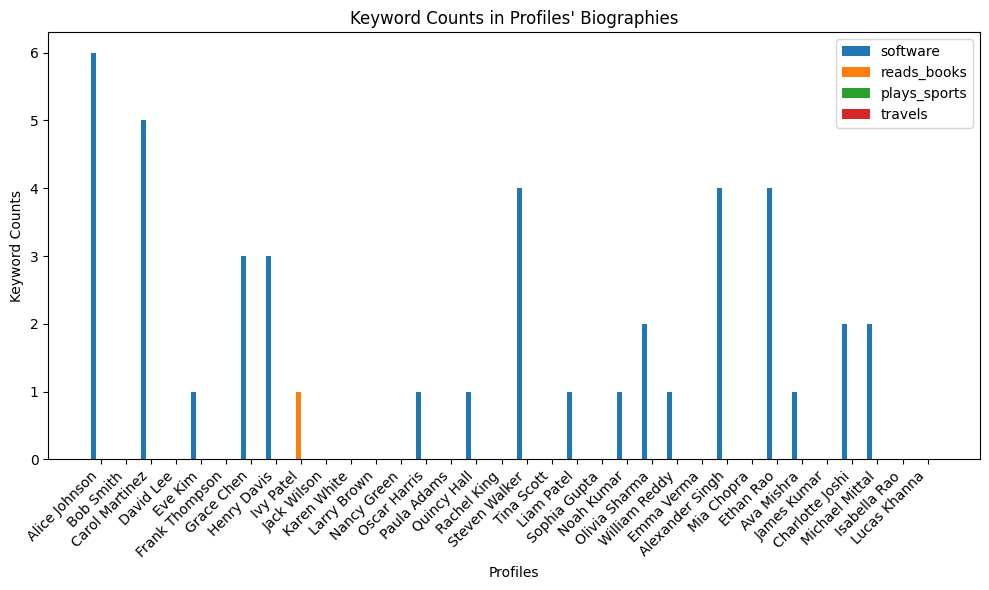

In [73]:
def count_keywords_in_bio(bio, keywords):
    bio_lower = bio.lower()
    counts = {category: sum(bio_lower.count(keyword) for keyword in keywords) for category, keywords in keywords.items()}
    return counts

def visualize_keyword_counts(profiles, keywords):
    categories = list(keywords.keys())
    num_profiles = len(profiles)
    num_categories = len(categories)

    counts_matrix = np.zeros((num_profiles, num_categories))

    for i, profile in enumerate(profiles):
        counts = count_keywords_in_bio(profile['bio'], keywords)
        for j, category in enumerate(categories):
            counts_matrix[i, j] = counts[category]

    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.2
    x = np.arange(num_profiles)

    for j, category in enumerate(categories):
        ax.bar(x + j * width, counts_matrix[:, j], width, label=category)

    ax.set_xticks(x + width * (num_categories - 1) / 2)
    ax.set_xticklabels([profile['name'] for profile in profiles])
    ax.set_xlabel('Profiles')
    ax.set_ylabel('Keyword Counts')
    ax.set_title('Keyword Counts in Profiles\' Biographies')
    ax.legend()

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage
visualize_keyword_counts(profiles, category_keywords)

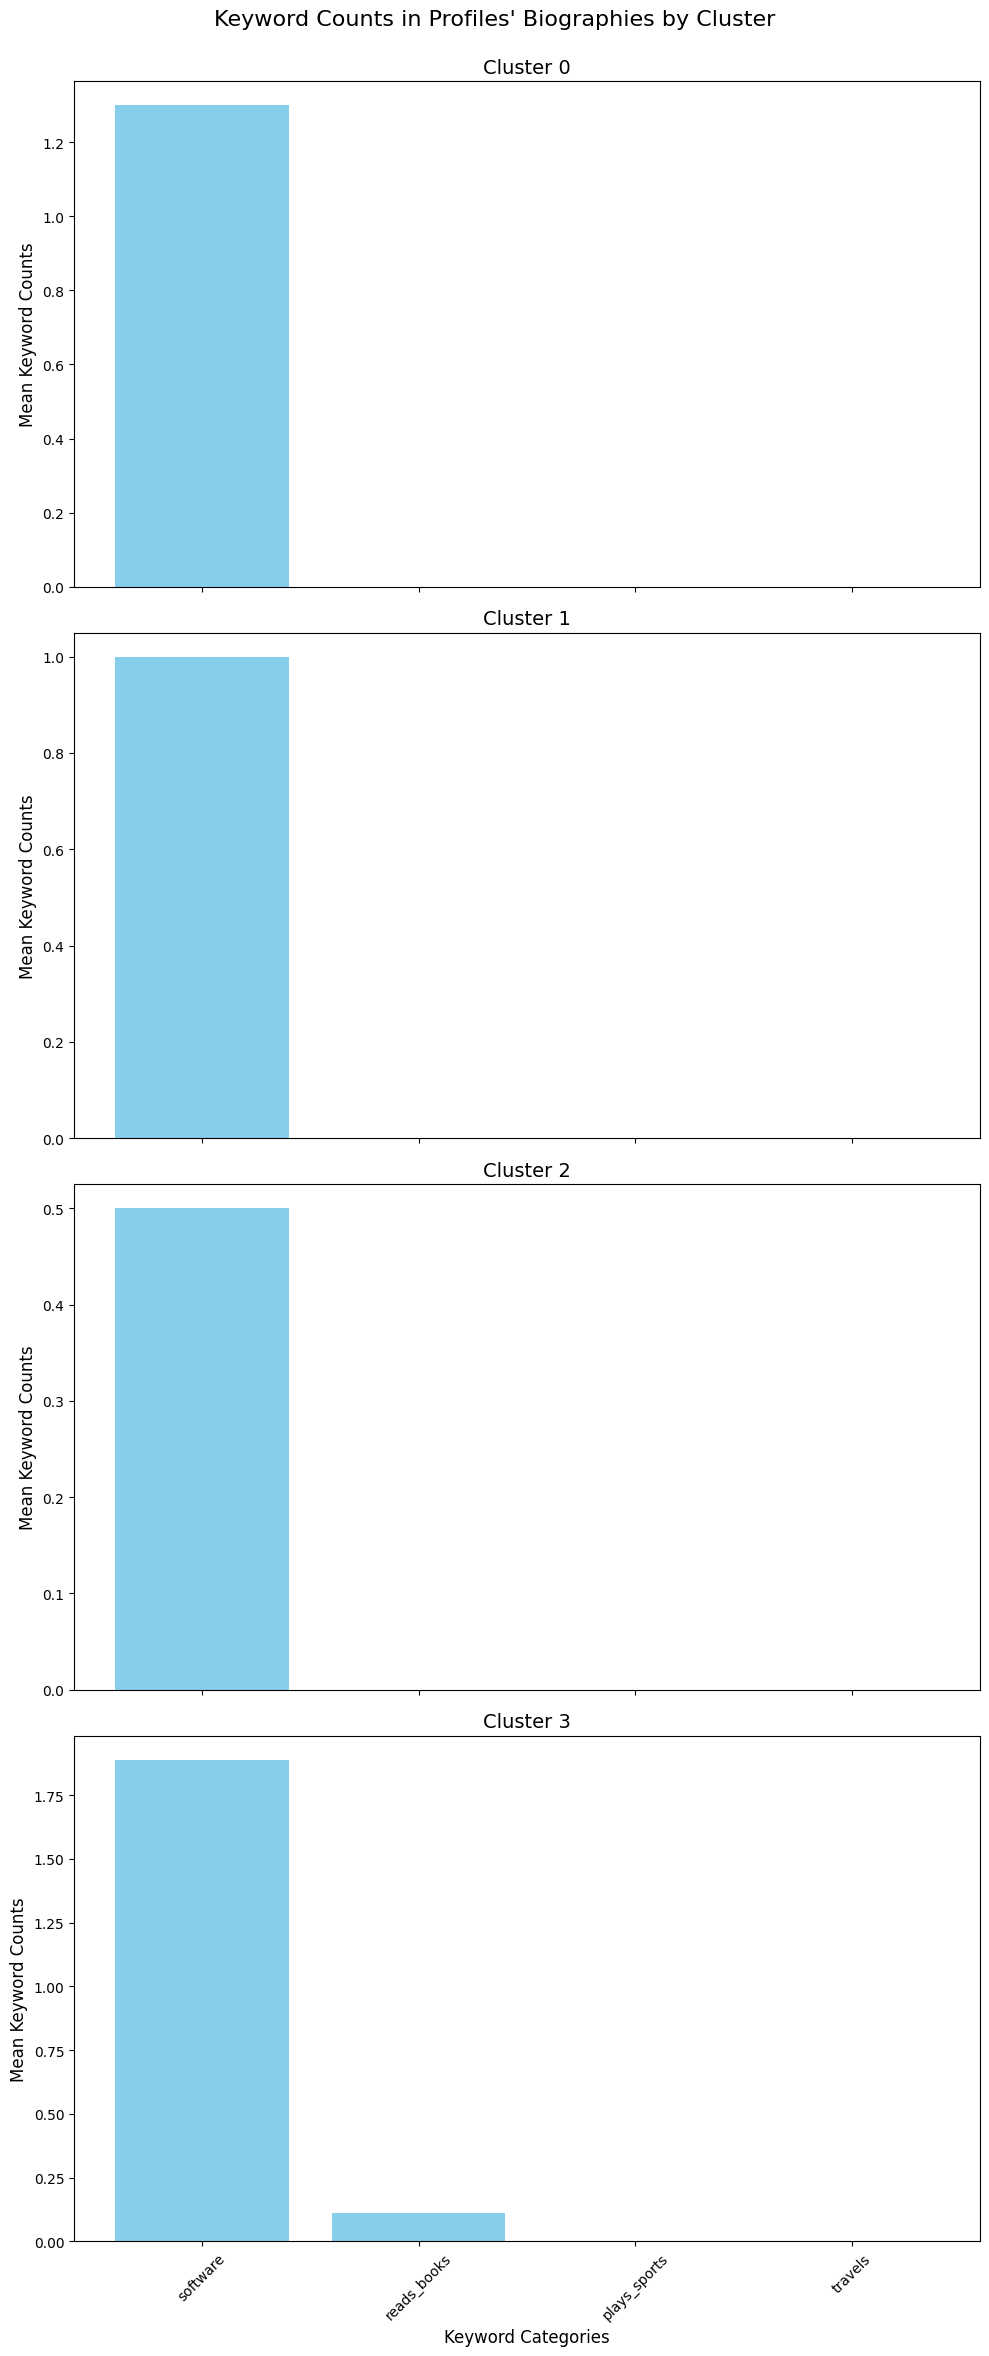

In [74]:
def count_keywords_in_bio(bio, keywords):
    bio_lower = bio.lower()
    counts = {category: sum(bio_lower.count(keyword) for keyword in keywords) for category, keywords in keywords.items()}
    return counts

def visualize_keyword_counts_cluster_wise(profiles, keywords):
    categories = list(keywords.keys())
    num_profiles = len(profiles)
    num_categories = len(categories)
    
    counts_matrix = np.zeros((num_profiles, num_categories))
    
    for i, profile in enumerate(profiles):
        counts = count_keywords_in_bio(profile['bio'], keywords)
        for j, category in enumerate(categories):
            counts_matrix[i, j] = counts[category]
    
    clusters = sorted(set(profile['cluster'] for profile in profiles))
    num_clusters = len(clusters)
    
    fig, axs = plt.subplots(num_clusters, 1, figsize=(10, 6 * num_clusters), sharex=True)
    fig.suptitle('Keyword Counts in Profiles\' Biographies by Cluster', fontsize=16)
    
    for cluster_id, ax in zip(clusters, axs):
        cluster_profiles = [profile for profile in profiles if profile['cluster'] == cluster_id]
        cluster_counts = counts_matrix[[profiles.index(profile) for profile in cluster_profiles]]
        
        ax.bar(categories, cluster_counts.mean(axis=0), color='skyblue')
        ax.set_title(f'Cluster {cluster_id}', fontsize=14)
        ax.set_ylabel('Mean Keyword Counts', fontsize=12)
        ax.tick_params(axis='x', labelrotation=45)
    
    plt.xlabel('Keyword Categories', fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

visualize_keyword_counts_cluster_wise(profiles, category_keywords)

In [75]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

def top_words_in_clusters(profiles, num_top_words=10):
    clusters = sorted(set(profile['cluster'] for profile in profiles))
    cluster_texts = {cluster: [] for cluster in clusters}
    
    for profile in profiles:
        cluster_texts[profile['cluster']].append(preprocess_text(profile['bio']))
    
    top_words_per_cluster = {}
    
    for cluster_id, texts in cluster_texts.items():
        all_text = ' '.join(texts)
        words = all_text.split()
        stopwords = set(sklearn_stopwords)
        words = [word for word in words if word not in stopwords]
        
        word_counts = Counter(words)
        top_words = word_counts.most_common(num_top_words)
        
        top_words_per_cluster[cluster_id] = top_words
    
    return top_words_per_cluster

top_words_per_cluster = top_words_in_clusters(profiles)

for cluster_id, top_words in top_words_per_cluster.items():
    print(f"Cluster {cluster_id}:")
    for i, (word, count) in enumerate(top_words, 1):
        print(f"{i}. {word}: {count}")
    print()

Cluster 0:
1. marketing: 6
2. years: 5
3. experience: 5
4. design: 5
5. digital: 5
6. development: 5
7. passion: 4
8. proficient: 4
9. web: 4
10. strong: 4

Cluster 1:
1. experience: 7
2. management: 7
3. years: 6
4. skilled: 5
5. business: 4
6. strong: 4
7. 5: 4
8. manager: 3
9. employee: 3
10. experienced: 3

Cluster 2:
1. analysis: 5
2. management: 4
3. skilled: 4
4. environmental: 4
5. years: 3
6. experience: 3
7. marketing: 3
8. expertise: 3
9. financial: 3
10. sales: 3

Cluster 3:
1. content: 5
2. strong: 5
3. experienced: 4
4. years: 4
5. skilled: 4
6. published: 4
7. background: 4
8. software: 3
9. python: 3
10. data: 3



### 1. Graph-Based Recommendations

Graph-based recommendation systems model relationships between entities (in this case, user profiles) using graph structures. Nodes represent profiles, and edges signify relationships or similarities between profiles based on various criteria such as shared interests, connections, or geographic proximity. Techniques such as Personalized PageRank can prioritize recommendations based on the importance of nodes (profiles) within the graph, while algorithms like Node2Vec can capture nuanced similarities between profiles by learning embeddings that preserve local and global graph structures. Additionally, Graph Convolutional Networks (GCNs) can leverage graph topology to enhance recommendations through iterative feature propagation and aggregation, thereby providing robust and context-aware suggestions that go beyond traditional similarity measures.

### 2. Hybrid Recommender Systems

Hybrid recommender systems combine multiple recommendation techniques to leverage their respective strengths, offering more accurate and diverse recommendations. By integrating content-based filtering (analyzing profile attributes like bios and interests), collaborative filtering (based on user interactions and similarities), and possibly context-aware or graph-based approaches, these systems optimize user satisfaction and engagement. Techniques like weighted averaging or ensemble methods can intelligently combine predictions from different models, enhancing the overall recommendation quality by mitigating individual weaknesses and enhancing coverage across diverse user preferences and behaviors.

### 3. Temporal Dynamics

Accounting for temporal dynamics in recommendation systems acknowledges that user preferences and behaviors evolve over time. This approach involves modeling how profiles change in terms of skills, interests, and job roles. Techniques such as time-aware matrix factorization adapt traditional collaborative filtering methods to incorporate time-stamped data, capturing user preferences' temporal patterns. Recurrent Neural Networks (RNNs) and variants like Long Short-Term Memory networks (LSTMs) are adept at sequential data modeling, allowing for the prediction of future user preferences based on past interactions. By considering the evolving nature of profiles, these methods ensure recommendations remain relevant and personalized over extended periods.

### 4. Personalization and Contextual Information

Personalization in recommendation systems customizes suggestions based on individual user characteristics and contextual information. Algorithms leverage user-specific data such as past interactions, preferences, demographics, and current context (e.g., job role, industry, location). Techniques like reinforcement learning or contextual bandits optimize recommendations by continuously learning from user feedback to refine predictions. Adaptive strategies adaptively adjust recommendations in real-time based on ongoing user interactions, ensuring relevance and responsiveness to evolving user needs. By integrating these approaches, recommendation systems can deliver tailored experiences that enhance user satisfaction and engagement, fostering long-term user retention and platform loyalty.

### 5. Natural Language Processing (NLP) Techniques

NLP techniques enhance recommendation systems by extracting and understanding textual information from profile bios and other textual data. Named Entity Recognition (NER) identifies important entities like skills, certifications, and job titles, enriching profile representations for more accurate recommendations. Sentiment analysis gauges the tone and sentiment expressed in bios, providing insights into user preferences and personality traits. Topic modeling identifies latent topics within bios, enabling a deeper understanding of users' professional interests and expertise. Summarization techniques condense lengthy bios into concise representations, facilitating efficient profile comparisons and enhancing recommendation quality. By leveraging these NLP advancements, recommendation systems can effectively interpret and utilize textual data to generate personalized and insightful suggestions for professional networking connections.

# Graph based Algo

In [76]:
graph = nx.Graph()

In [77]:
for profile in profiles:
    graph.add_node(profile["name"], bio=profile["bio"], interests=profile["interests"], location=profile["location"])


In [78]:
for i in range(len(profiles)):
    for j in range(i + 1, len(profiles)):
        profile1 = profiles[i]
        profile2 = profiles[j]
        interests1 = list(profile1["interests"].values())
        interests2 = list(profile2["interests"].values())
        similarity_score = cosine_similarity([interests1], [interests2])[0][0]
        if similarity_score > 0.5:
            graph.add_edge(profile1["name"], profile2["name"], weight=similarity_score)

In [79]:
def personalized_pagerank_recommendations(graph, profiles, profile_name, num_recommendations=3):
    if profile_name not in graph.nodes:
        return []
    
    personalized_pagerank = nx.pagerank(graph, personalization={profile_name: 1})
    sorted_profiles = sorted(personalized_pagerank.items(), key=lambda x: x[1], reverse=True)
    recommendations = []
    for profile, score in sorted_profiles:
        if profile != profile_name:
            recommendations.append(profile)
        if len(recommendations) >= num_recommendations:
            break
    recommended_profiles_info = []
    for recommendation in recommendations:
        profile_info = {
            "name": recommendation,
            "bio": graph.nodes[recommendation]["bio"],
            "interests": graph.nodes[recommendation]["interests"]
        }
        recommended_profiles_info.append(profile_info)
    
    return recommended_profiles_info

In [80]:
profile_name = "Alice Johnson"
# {
#         "name": "Alice Johnson",
#         "bio": "Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp.",
#         "interests": {
#             "reads_books": 80, 
#             "plays_sports": 20,
#             "travels": 50
#         },
#         "location": "Bangalore"
#     },
recommendations = personalized_pagerank_recommendations(graph, profiles, profile_name)
for recommendation in recommendations:
    print(f"Recommended Profile: {recommendation['name']}")
    print(f"Bio: {recommendation['bio']}")
    print(f"Interests: {recommendation['interests']}")
    print()

Recommended Profile: Ethan Rao
Bio: Software Developer specializing in web application development. Proficient in JavaScript, React, and Node.js. Experienced in building scalable and responsive web solutions. Passionate about open-source development.
Interests: {'reads_books': 50, 'plays_sports': 30, 'travels': 50}

Recommended Profile: Charlotte Joshi
Bio: Human Resources Specialist with a focus on talent acquisition and employee development. Experienced in HR strategy development and implementation. Strong communication and organizational skills.
Interests: {'reads_books': 50, 'plays_sports': 40, 'travels': 60}

Recommended Profile: Mia Chopra
Bio: Digital Marketer with a focus on content strategy and social media management. Over 5 years of experience in developing and executing digital marketing campaigns. Skilled in SEO, SEM, and email marketing.
Interests: {'reads_books': 60, 'plays_sports': 40, 'travels': 70}



# A hybrid profile recommendation system

A hybrid profile recommendation system that uses graph-based methods, vector embeddings, and clustering, we'll follow a series of steps:

1. **Profile Data Representation**:
   - Represent each profile as a vector embedding using features extracted from the profile data (e.g., skills, bio keywords, interests).
   - Create a graph where nodes represent profiles and edges represent similarities or connections between profiles based on common features (e.g., interests, location).

2. **Graph Construction**:
   - Construct a graph using the profiles, where edges can be weighted based on the similarity of profile features (e.g., cosine similarity of vector embeddings).

3. **Vector Embeddings**:
   - Use Natural Language Processing (NLP) techniques to convert text-based features like bio and interests into numerical embeddings.
   - Combine these embeddings to form a comprehensive feature vector for each profile.

4. **Clustering**:
   - Apply clustering algorithms (e.g., K-means, DBSCAN) on the vector embeddings to group similar profiles together.
   - This will help in identifying communities or clusters of similar profiles.

5. **City-Based Filtering**:
   - After clustering, filter profiles based on the user's city to provide localized recommendations.
   - Use the graph to find closely connected profiles within the same city.

In [81]:
model = SentenceTransformer('all-MiniLM-L6-v2')
bios = [profile['bio'] for profile in profiles]
bio_embeddings = model.encode(bios)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [82]:
interests = [list(profile['interests'].values()) for profile in profiles]
interest_embeddings = np.array(interests)

In [83]:
combined_embeddings = np.hstack((bio_embeddings, interest_embeddings))

In [84]:
G = nx.Graph()
for i, profile in enumerate(profiles):
    G.add_node(i, profile=profile)

In [85]:
similarity_matrix = cosine_similarity(combined_embeddings)
threshold = 0.5  # similarity threshold
for i in range(len(profiles)):
    for j in range(i + 1, len(profiles)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

In [86]:
kmeans = KMeans(n_clusters=5)  
clusters = kmeans.fit_predict(combined_embeddings)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [87]:
for i, profile in enumerate(profiles):
    profile['cluster'] = clusters[i]

In [88]:
profiles[3]

{'name': 'David Lee',
 'bio': 'Marketing Specialist with over 7 years of experience in digital marketing, SEO, and content strategy. Proven track record in increasing brand awareness and driving online engagement. Skilled in social media management and email marketing campaigns.',
 'interests': {'reads_books': 30, 'plays_sports': 80, 'travels': 40},
 'location': 'Hyderabad',
 'cluster': 3}

In [89]:
def recommend_profiles(current_city, profiles, G, target_cluster=None):
    recommendations = []
    for node in G.nodes():
        if profiles[node]['location'] == current_city:
            if target_cluster is None or profiles[node]['cluster'] == target_cluster:
                recommendations.append(profiles[node])
    return recommendations

recommendations = recommend_profiles("Bangalore", profiles, G)
for i in recommendations:
    print(i,end='\n\n')

{'name': 'Alice Johnson', 'bio': 'Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp.', 'interests': {'reads_books': 80, 'plays_sports': 20, 'travels': 50}, 'location': 'Bangalore', 'cluster': 0}

{'name': 'Karen White', 'bio': 'UX Designer with a passion for creating intuitive and user-friendly interfaces. Over 5 years of experience in wireframing, prototyping, and user testing. Skilled in Sketch, Figma, and Adobe XD. Dedicated to improving user experience through innovative design solutions.', 'interests': {'reads_books': 40, 'plays_sports': 50, 'travels': 80}, 'location': 'Bangalore', 'cluster': 4}

{'name': 'Liam Patel', 'bio': 'AI Researcher specializing in natural language processing and deep learning. PhD in Computer Science with a focus on neural networks and text generation models. Experienced

# Gemma Bio Generation 

In [90]:
!pip install -q -U torch immutabledict sentencepiece

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.2+cpu requires torch==2.1.2, but you have torch 2.3.1 which is incompatible.
torchtext 0.16.2+cpu requires torch==2.1.2, but you have torch 2.3.1 which is incompatible.
torchvision 0.16.2+cpu requires torch==2.1.2, but you have torch 2.3.1 which is incompatible.


In [91]:
VARIANT = '2b-it'
MACHINE_TYPE = 'cuda'

In [92]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_1.1_instruct_2b_en")

Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Kaggle notebook...
Attachin

In [93]:
user_input_bio = "Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp."

In [94]:
gemma_lm.generate(f"generate more efficient and professional linkedin bio from this {user_input_bio}", max_length=100)

I0000 00:00:1719469631.408816     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-06-27 06:27:11.410157: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-06-27 06:27:11.410537: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


'generate more efficient and professional linkedin bio from this Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp.\n\n**Improvements:**\n\n* **Stronger focus on skills and experience:** Removed "Experienced" and "passionate" as they are redundant with the keywords "skilled" and "leading."\n* **Quantify achievements:** Replaced "'

In [95]:
gemma_lm.generate(f"consider this Linkedin profile bio  {user_input_bio} and enhance it using more professional keywords and phrases ", max_length=100)

'consider this Linkedin profile bio  Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp. and enhance it using more professional keywords and phrases \n\n**Improvements:**\n\n* Added relevant keywords and phrases to enhance searchability\n* Quantified achievements with specific numbers and percentages\n* Used strong action verbs to describe skills and experience\n* Added a'

In [96]:
gemma_lm.generate(f"consider this Linkedin profile bio  {user_input_bio} and rewrite it using more professional keywords and phrases ", max_length=100)

'consider this Linkedin profile bio  Experienced Software Engineer with 10 years in the tech industry. Skilled in Python, Java, and cloud computing. Passionate about developing scalable software solutions and mentoring junior developers. Currently leading a team at TechCorp. and rewrite it using more professional keywords and phrases \n\n**Experienced Software Engineer with a decade of experience in the tech industry.**\n\n**Technical Expertise:**\n\n* Python\n* Java\n* Cloud Computing\n\n**Professional Highlights:**\n\n* Leading a team'

# New Profiie embedding and clustering

In [97]:
new_profiles = pd.read_csv('/kaggle/input/cleaned-profiles/cleaned_profiles.csv')

In [98]:
new_profiles.head(10)

,Unnamed: 0,Label,Cleaned_Text
0,0,ceo,highstakes world business mr david chen ascend...
1,1,ceo,competitive realm business ms sophia patel eme...
2,2,ceo,everevolving landscape business ms sophia pate...
3,3,ceo,everchanging landscape business ms sophia pate...
4,4,ceo,everchanging landscape business mr david chen ...
5,5,ceo,everevolving landscape business mr david chen ...
6,6,ceo,everchanging landscape business mr david chen ...
7,7,ceo,everchanging landscape business ms sophia pate...
8,8,ceo,highstakes world business ms emily carter asce...
9,9,ceo,highstakes world business ms emily carter asce...


In [99]:
new_profiles.get('Cleaned_Text')[0]

'highstakes world business mr david chen ascended pinnacle success chief executive officer chen enterprises exceptional ability make sound decisions intense pressure coupled remarkable resourcefulness propelled company forefront industry confronted complex challenges timesensitive dilemmas davids mind raced clarity swiftly analyzing data weighing risks opportunities formulating strategies resolved immediate crises also positioned company longterm growth reputation decisive leader spread like wildfire inspiring awe admiration among peers subordinates alike complementing razorsharp decisionmaking acumen davids innate ability identify leverage companys assets tangible intangible maximize returns understood resources merely financial capital also included skills knowledge networks employees empowering team providing necessary support fostered environment innovation flourished davids resourcefulness extended beyond financial management also excelled allocating human resources technology ass

In [100]:
def generate_word_cloud(text, label):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {label}')
    plt.axis('off')
    plt.show()

In [101]:
def find_top_words_by_label(df):
    labels = df['Label'].unique()
    for label in labels:
        text_for_label = ' '.join(df[df['Label'] == label]['Cleaned_Text'])
        print()
        generate_word_cloud(text_for_label, label)
        print()

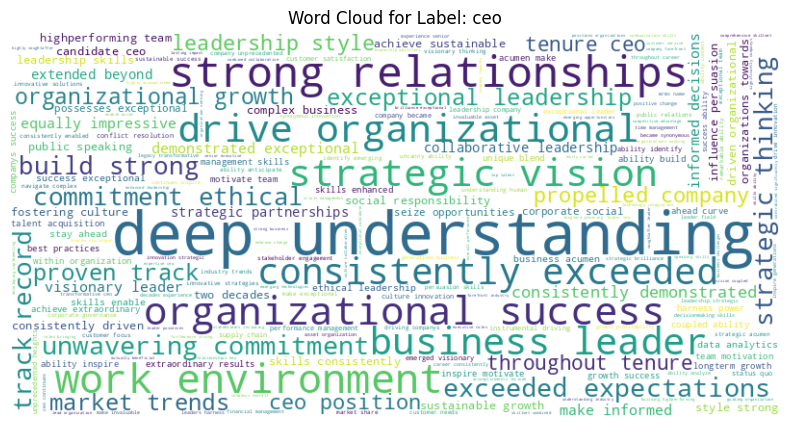

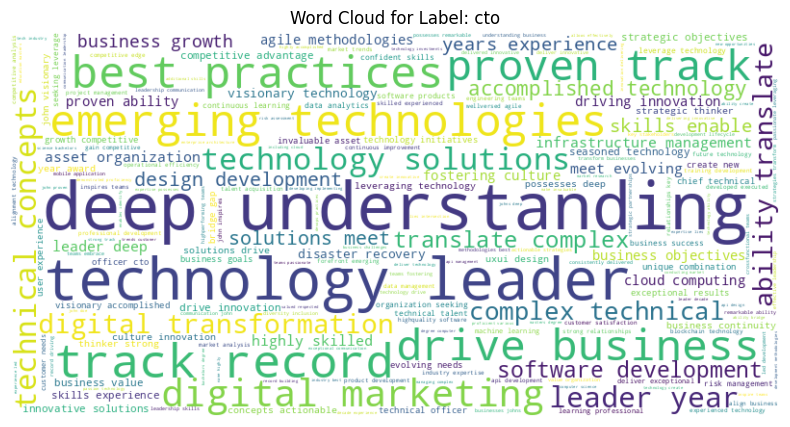

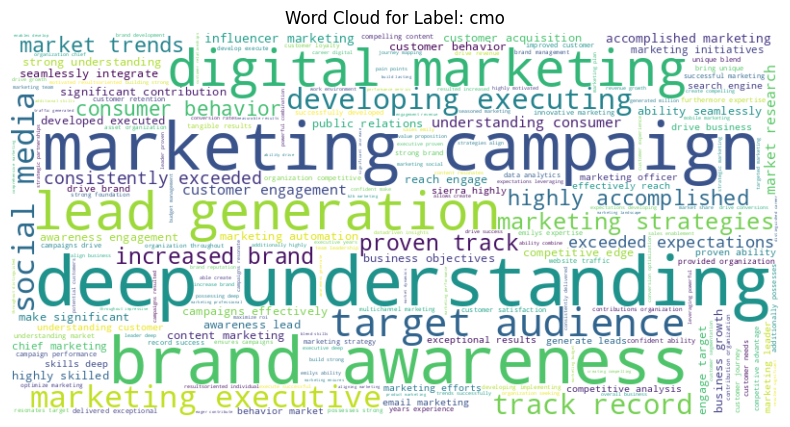

In [102]:
find_top_words_by_label(new_profiles)

In [103]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

encoded_dict = tokenizer.batch_encode_plus(new_profiles['Cleaned_Text'].tolist(), 
                                          add_special_tokens=True,
                                          max_length=256,
                                          padding=True,
                                          truncation=True,
                                          return_attention_mask=True,
                                          return_tensors='pt')

input_ids = encoded_dict['input_ids']
attention_masks = encoded_dict['attention_mask']

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model.eval()

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)

embeddings = outputs.last_hidden_state[:, 0, :].numpy() 

In [ ]:
embeddings.shape

In [ ]:
def calculate_distortion(data, max_k):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    return distortions

In [ ]:
max_k = 10  # Maximum number of clusters to consider
distortions = calculate_distortion(embeddings, max_k)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), distortions, marker='o', linestyle='--', color='b')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, max_k + 1))
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(embeddings)
new_profiles['Cluster'] = clusters

new_profiles[['Cleaned_Text', 'Cluster']]

In [ ]:
cluster_texts = {cluster: [] for cluster in new_profiles['Cluster'].unique()}

for index, row in new_profiles.iterrows():
    cluster_texts[row['Cluster']].append(row['Cleaned_Text'])

for cluster in cluster_texts:
    cluster_texts[cluster] = ' '.join(cluster_texts[cluster])

In [ ]:
tokenizer = nltk.tokenize.word_tokenize
tokenized_texts = {cluster: tokenizer(cluster_texts[cluster]) for cluster in cluster_texts}

word_counts = {cluster: Counter(tokens) for cluster, tokens in tokenized_texts.items()}

In [ ]:
top_words_per_cluster = {}
for cluster, word_count in word_counts.items():
    top_words = word_count.most_common(5)
    top_words_per_cluster[cluster] = top_words

for cluster, top_words in top_words_per_cluster.items():
    print(f"Cluster {cluster}:")
    for word, count in top_words:
        print(f"{word}: {count}")
    print()

In [ ]:
clusters = new_profiles['Cluster'].values

In [ ]:
cluster_centers = []
for cluster_id in sorted(new_profiles['Cluster'].unique()):
    cluster_center = np.mean(embeddings[clusters == cluster_id], axis=0)
    cluster_centers.append(cluster_center)

distances = pairwise_distances(cluster_centers, metric='euclidean')

In [ ]:
# Applying Multidimensional Scaling (MDS) to reduce dimensionality to 2D
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embeddings_2d = mds.fit_transform(distances)

In [ ]:
embeddings_2d

In [ ]:
from matplotlib.cm import get_cmap

In [ ]:
plt.figure(figsize=(8, 8))
cmap = get_cmap('viridis')
for cluster_id, (x, y) in enumerate(embeddings_2d):
    plt.scatter(x, y, color=cmap(cluster_id / len(cluster_centers)), s=100, alpha=0.8, label=f'Cluster {cluster_id}')
    plt.text(x, y, f'Cluster {cluster_id}', fontsize=12, ha='right')

plt.title('MDS Plot of Cluster Distances')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3d

In [ ]:
cluster_centers = []
for cluster_id in sorted(new_profiles['Cluster'].unique()):
    cluster_center = np.mean(embeddings[clusters == cluster_id], axis=0)
    cluster_centers.append(cluster_center)

cluster_centers = np.array(cluster_centers)
distances = pairwise_distances(cluster_centers, metric='euclidean')

In [ ]:
# Apply Multidimensional Scaling (MDS) to reduce dimensionality to 3D
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
embeddings_3d = mds.fit_transform(distances)

In [ ]:
embeddings_3d

In [ ]:
fig = go.Figure()

for cluster_id, (x, y, z) in enumerate(embeddings_3d):
    fig.add_trace(go.Scatter3d(
        x=[x],
        y=[y],
        z=[z],
        mode='markers+text',
        marker=dict(size=10, opacity=0.8),
        text=[f'Cluster {cluster_id}'],
        textposition='top center'
    ))

fig.update_layout(
    title='MDS Plot of Cluster Distances in 3D',
    scene=dict(
        xaxis_title='MDS Dimension 1',
        yaxis_title='MDS Dimension 2',
        zaxis_title='MDS Dimension 3'
    )
)

fig.show()

# Vector Embedding store

In [5]:
resumes = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')

In [6]:
resumes.drop(['ID','Resume_html'], inplace=True, axis=1)

In [7]:
resumes.sample(10)

,Resume_str,Category
2277,BILINGUAL LANGUAGE ARTS SIXTH GRADE T...,ARTS
196,3D DESIGNER/ GRAPHIC DESIGNER ...,DESIGNER
2219,VICE PRESIDENT Summary Seeki...,BANKING
1777,CHEMICAL ENGINEERING INTERN Obj...,ENGINEERING
1956,GENERAL CONSTRUCTION INTERN Obj...,CONSTRUCTION
1803,INDUSTRIAL ENGINEERING INTERN P...,ENGINEERING
429,KINDERGARTEN TEACHER Summar...,TEACHER
2442,MATERIAL CONTROL SPECIALIST Sum...,AVIATION
1443,SENIOR EXECUTIVE CHEF Execu...,CHEF
2072,"MARKETING, COMMNICATIONS, & PUBLIC RE...",PUBLIC-RELATIONS


In [8]:
resumes.get('Resume_str')[4][:500]

"         HR MANAGER         Skill Highlights           HR SKILLS  HR Department Startup  Three New Organization Startups  Employment Law  FMLA/ADA/EEO/WC  Mediation & Advocacy  HR Policies & Procedures\t*Staff Recruitment & Retention  Salary Negotiations  Employee Relations  Benefits Administration  Unemployment Administration  Worker's Compensation Administration  Orientation & On-Boarding  HRIS Technologies  Training & Development  Performance Management  Organizational Development  HR Program/"

In [9]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text) 
    text = re.sub(r'\.+', '.', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    cleaned_text = ' '.join(filtered_tokens)
    return cleaned_text.strip()

resumes['Cleaned_Text'] = resumes['Resume_str'].apply(clean_text)
resumes['labels'] = resumes['Category'].astype('category').cat.codes

In [11]:
resumes.get('Cleaned_Text')[4][:1000]

'HR MANAGER Skill Highlights HR SKILLS HR Department Startup Three New Organization Startups Employment Law FMLAADAEEOWC Mediation Advocacy HR Policies Procedures Staff Recruitment Retention Salary Negotiations Employee Relations Benefits Administration Unemployment Administration Workers Compensation Administration Orientation OnBoarding HRIS Technologies Training Development Performance Management Organizational Development HR ProgramProject Management HRIS applications Lawson Paychex Kronos ADP MS Office Word Excel PowerPoint Publisher Access Visio Outlook Professional Experience HR Manager Jan 2015 Current Company Name City State Manage Human Resource function eCycles corporate office well fulfillment data center consisting benefits compensation administration payroll employee relations policy compliance recruitment Key Results Foster associateoriented culture emphasizes continuous improvement team work high performance quality Ensure organizational conformation applicable HR relat

In [12]:
dataset = Dataset.from_pandas(resumes)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(resumes['Category'].unique()))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def tokenize_function(examples):
    return tokenizer(examples['Cleaned_Text'], padding='max_length', truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.map(lambda examples: {'labels': examples['labels']}, batched=True)

Map:   0%|          | 0/2484 [00:00<?, ? examples/s]

Map:   0%|          | 0/2484 [00:00<?, ? examples/s]

In [14]:
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [15]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


In [16]:
trainer.train()

model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,3.169000
20,3.178600
30,3.194200
40,3.190200
50,3.139100
60,3.131900
70,3.138100
80,3.117400
90,3.076100
100,3.087100


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


('./fine-tuned-bert/tokenizer_config.json',
 './fine-tuned-bert/special_tokens_map.json',
 './fine-tuned-bert/vocab.txt',
 './fine-tuned-bert/added_tokens.json')

In [17]:
model = BertForSequenceClassification.from_pretrained('./fine-tuned-bert')
tokenizer = BertTokenizer.from_pretrained('./fine-tuned-bert')

In [18]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
encoded_dict = tokenizer.batch_encode_plus(resumes['Cleaned_Text'].tolist(),
                                           add_special_tokens=True,
                                           max_length=512,
                                           padding=True,
                                           truncation=True,
                                           return_attention_mask=True,
                                           return_tensors='pt')

input_ids = encoded_dict['input_ids']
attention_masks = encoded_dict['attention_mask']

In [ ]:
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)

embeddings = outputs.last_hidden_state[:, 0, :].numpy()

resumes['embeddings'] = list(embeddings)
resumes[['Resume_str', 'embeddings']]